In [1]:
import os
import numpy as np
from tqdm import tqdm
from nilearn import plotting
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr
import pickle
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
def vectorized_correlation(x,y,dim=0):
    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, ddof=1, keepdims=True)
    y_std = y.std(axis=dim, ddof=1, keepdims=True)

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()
    
def list_rep(myList: list, reps: int):
    #returns a list of items in "mylist" that are repeated "reps" number of times
    repList = []
    # traverse for all elements
    for x in myList:
        if x not in repList: 
            count = myList.count(x)
            if count == reps:
                repList.append(x)
    return repList

In [3]:
class arguments():
    def __init__(self) -> None:
        self.root = "/data/vision/oliva/scratch/datasets/CC2017/video_fmri_dataset"
        self.task = "train"
        self.plot = True
        self.verbose = True
args = arguments()

nvertices = 91282

if args.task == 'train':
    numreps = 2
elif args.task == 'test':
    numreps = 10

#generate unique pairs of repetition indices
pairs = []
for i in range(numreps):
    for j in range(i+1, numreps):
        pairs.append((i,j))

sub_idx = 2
sub = 3

In [4]:
subject_intrasc = f"subject{sub}"
fmri_data = np.zeros((len(pairs), nvertices))
if args.verbose:
    print(f"loading betas from subject {sub}")
#load raw ts estimates
with open(os.path.join(args.root, "TSTrialEstimates", subject_intrasc, "estimates-prepared", "step01", f"{subject_intrasc}_z=0_TSTrialEstimates_task-{args.task}.pkl"), 'rb') as f:
    estimates_noz_test, condition_order = pickle.load(f) #shape nvideos, nvertices 


loading betas from subject 3


In [5]:
repeated_conditions = list_rep(condition_order, numreps) #just get the conditions repeated exactly numpreps times
estimates_noz_test_matrix = np.zeros((nvertices, numreps, len(repeated_conditions)))
for count, cond in enumerate(repeated_conditions):
    idx = [i for i, c in enumerate(condition_order) if c == cond] #all indices of repeated condition "cond"
    estimates_noz_test_matrix[:,:,count] = estimates_noz_test[idx, :].T


In [6]:
estimates_noz_test_matrix.shape

(91282, 2, 4302)

seg1_begin-2_end-4
seg2_begin-2_end-4
[-0.11562768]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233

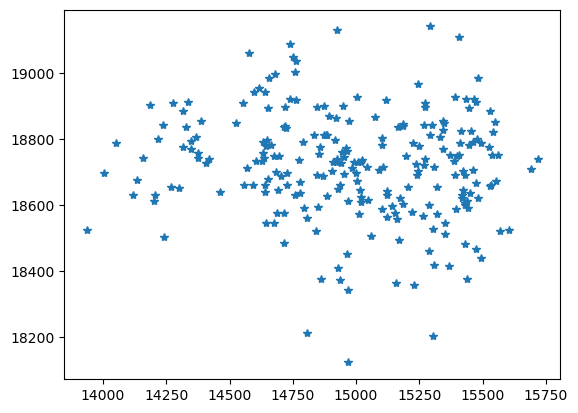

In [7]:
offset = 1
start_idx = 239*(offset-1)
end_idx = 239*(offset)
print(repeated_conditions[start_idx])
print(repeated_conditions[end_idx])
print(vectorized_correlation(estimates_noz_test_matrix[20000, 0, start_idx:end_idx].T, estimates_noz_test_matrix[20000, 1, start_idx:end_idx].T))
idx_vec = np.array(range(start_idx,end_idx))
print(idx_vec)
np.random.shuffle(idx_vec)
print(idx_vec)
plt.plot(estimates_noz_test_matrix[20000,0,idx_vec], estimates_noz_test_matrix[20000,1,idx_vec], '*')
plt.show()

In [8]:
segments = {f"seg{s}": [] for s in range(1,19)}
for idx, r in enumerate(repeated_conditions):
    seg = r.split('_')[0]
    segments[seg].append(idx)

In [9]:

intraSC = 0
for segment, idx in segments.items():
    print(f"segment {segment}")
    np.random.shuffle(idx) #in place
    print(idx)
    intraSC += vectorized_correlation(estimates_noz_test_matrix[:, 0, idx].T, estimates_noz_test_matrix[:, 1, idx].T)

intraSC = intraSC/len(segments) #average over segments
print(np.nanmax(intraSC))

segment seg1
[135, 113, 42, 60, 39, 100, 97, 167, 13, 124, 224, 211, 74, 170, 37, 49, 159, 210, 223, 132, 78, 79, 24, 106, 2, 174, 203, 137, 141, 40, 163, 176, 116, 182, 87, 213, 134, 142, 43, 101, 44, 99, 226, 154, 55, 33, 166, 47, 0, 122, 188, 233, 168, 1, 148, 20, 153, 115, 15, 32, 16, 94, 90, 65, 120, 61, 50, 17, 98, 114, 107, 158, 197, 152, 6, 53, 102, 200, 29, 131, 205, 189, 216, 199, 83, 162, 146, 31, 217, 181, 222, 75, 119, 186, 177, 68, 76, 54, 58, 71, 136, 117, 121, 95, 215, 133, 64, 201, 219, 195, 11, 22, 126, 196, 123, 171, 77, 93, 21, 66, 202, 82, 147, 70, 179, 12, 56, 138, 103, 80, 69, 46, 7, 234, 180, 160, 227, 190, 92, 204, 145, 149, 5, 155, 164, 161, 221, 85, 191, 63, 23, 109, 143, 169, 4, 183, 27, 229, 173, 192, 235, 193, 231, 218, 208, 128, 25, 225, 73, 38, 18, 228, 140, 62, 10, 220, 45, 127, 209, 36, 130, 184, 26, 129, 185, 139, 118, 3, 89, 67, 81, 212, 41, 91, 238, 51, 88, 150, 237, 105, 165, 236, 84, 214, 52, 144, 28, 232, 86, 172, 9, 112, 14, 194, 157, 34, 230, 2

/tmp/ipykernel_3325852/1505344762.py:12: RuntimeWarning: invalid value encountered in true_divide
  corr = bessel_corrected_covariance / (x_std * y_std)


segment seg6
[1379, 1429, 1373, 1415, 1298, 1301, 1312, 1393, 1210, 1213, 1208, 1372, 1404, 1431, 1377, 1391, 1353, 1364, 1288, 1352, 1397, 1235, 1279, 1355, 1224, 1337, 1327, 1316, 1375, 1241, 1321, 1244, 1344, 1262, 1398, 1378, 1237, 1306, 1296, 1406, 1303, 1260, 1433, 1354, 1197, 1412, 1261, 1333, 1223, 1230, 1251, 1248, 1394, 1250, 1254, 1422, 1207, 1399, 1341, 1290, 1351, 1195, 1204, 1323, 1384, 1311, 1374, 1304, 1318, 1361, 1314, 1270, 1371, 1293, 1256, 1332, 1225, 1275, 1336, 1282, 1278, 1362, 1202, 1203, 1300, 1367, 1212, 1229, 1390, 1329, 1366, 1221, 1369, 1389, 1243, 1380, 1302, 1420, 1386, 1370, 1307, 1277, 1259, 1430, 1233, 1409, 1255, 1350, 1291, 1343, 1205, 1284, 1196, 1305, 1271, 1325, 1211, 1342, 1266, 1414, 1349, 1411, 1395, 1416, 1402, 1335, 1308, 1315, 1299, 1426, 1227, 1392, 1218, 1331, 1309, 1228, 1226, 1421, 1292, 1419, 1387, 1214, 1410, 1408, 1376, 1231, 1330, 1365, 1280, 1220, 1219, 1348, 1294, 1338, 1234, 1417, 1199, 1198, 1347, 1200, 1360, 1236, 1324, 1216, 13

In [10]:
print(np.nanmean(intraSC))

0.11198809395939514


plotting IntraSC results


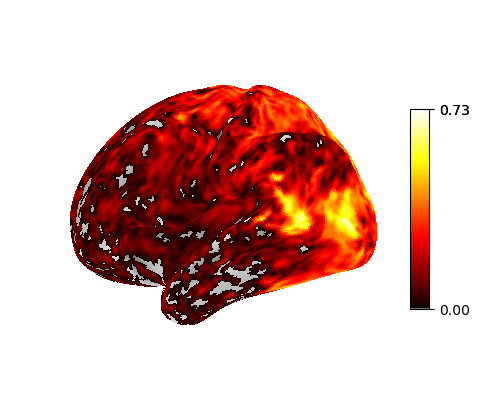

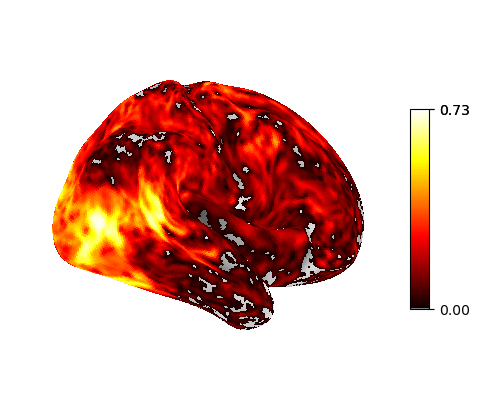

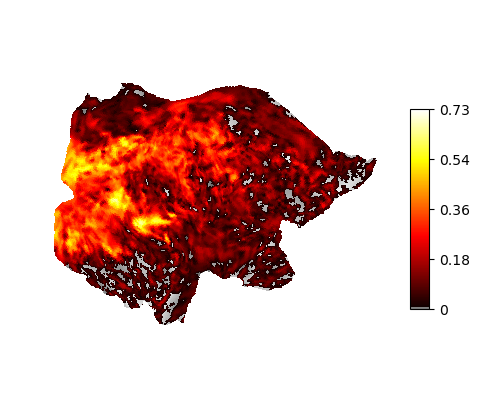

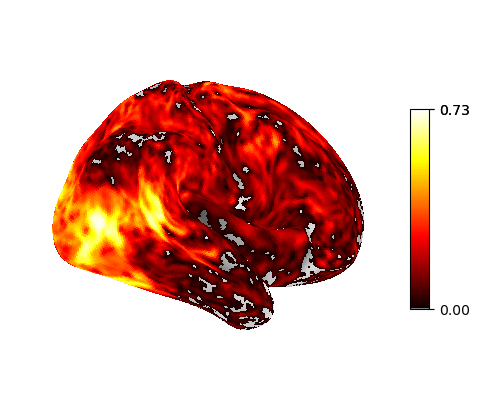

In [15]:
views = ['lateral', 'medial'] #['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']
if args.verbose:
    print("plotting IntraSC results")
#plot_root = os.path.join(args.root, "IntraSC_TS", subject_intrasc )
#if not os.path.exists(plot_root):
#    os.makedirs(plot_root)
task = args.task
intraSC[intraSC < 0] = 0 #treshold by 0
stat = intraSC
max_val = np.nanmax(stat)
#inflated brain
for hemi in ['left','right']:
    mesh = hcp.mesh.inflated
    cortex_data = hcp.cortex_data(stat)
    bg = hcp.mesh.sulc
    for view in views:
        display = plotting.plot_surf_stat_map(mesh, cortex_data, hemi=hemi,
        threshold=0.01, bg_map=bg, view=view, vmax=max_val)

        colorbar = display.axes[1]
        custom_ticks = np.array([0, 0.5679356, max_val])
        custom_labels = [f"{tick:.2f}" for tick in custom_ticks]
        colorbar.set_yticks(custom_ticks)
        colorbar.set_yticklabels(custom_labels)

        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-inflated_hemi-{hemi}_view-{view}.png"), dpi=300)
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-inflated_hemi-{hemi}_view-{view}.jpg"))
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-inflated_hemi-{hemi}_view-{view}.svg"))
        plt.show()
        #plt.close()
    #flattened brain
    if hemi == 'left':
        cortex_data = hcp.left_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_left, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_left, colorbar=True, cmap='hot', vmax=max_val)
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-left.png"), dpi=300)
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-left.jpg"))
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-left.svg"))
        plt.show()
        #plt.close()
    if hemi == 'right':
        cortex_data = hcp.right_cortex_data(stat)
        display = plotting.plot_surf(hcp.mesh.flat_right, cortex_data,
        threshold=0.01, bg_map=hcp.mesh.sulc_right, colorbar=True, cmap='hot', vmax=max_val)
        plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-right.png"), dpi=300)
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-right.jpg"))
        #plt.savefig(os.path.join(plot_root, f"{subject_intrasc}_intrasc_task-{task}_mesh-flat_hemi-right.svg"))
        plt.show()
        #plt.close()